In [13]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
import librosa
import librosa.display
from IPython.display import Audio

In [15]:
paths = []
labels = []
for dirname, _, filenames in os.walk('Datasets\Tess\TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
C:\Users\kille\AppData\Local\Temp\ipykernel_7292\2441779745.py:3: SyntaxWarning: invalid escape sequence '\T'
  for dirname, _, filenames in os.walk('Datasets\Tess\TESS Toronto emotional speech set data'):


In [16]:
# Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,Datasets\Tess\TESS Toronto emotional speech se...,angry
1,Datasets\Tess\TESS Toronto emotional speech se...,angry
2,Datasets\Tess\TESS Toronto emotional speech se...,angry
3,Datasets\Tess\TESS Toronto emotional speech se...,angry
4,Datasets\Tess\TESS Toronto emotional speech se...,angry


In [17]:
df['label'].value_counts()

label
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

In [18]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [19]:
extract_mfcc(df['speech'][0])

array([-3.96986206e+02,  7.74405365e+01, -1.95927906e+01, -2.16666889e+01,
       -2.11275601e+00,  1.00753632e+01, -2.03667068e+01, -6.09244919e+00,
       -7.21228313e+00, -5.57366073e-01, -1.83255339e+00,  2.02101454e-01,
        7.27551103e-01,  1.31773746e+00,  2.88633752e+00,  2.85579062e+00,
       -4.71292162e+00, -4.43651056e+00, -1.62115955e+00, -1.02398405e+01,
       -7.55126190e+00, -1.79688025e+00, -7.03765249e+00,  9.43658352e+00,
        8.35585308e+00,  2.17123604e+01,  1.92169914e+01,  2.03489304e+01,
        1.34133663e+01,  8.33917236e+00,  3.94722104e-01,  5.11131477e+00,
        9.56873894e+00,  5.45486832e+00,  2.50996327e+00, -1.82390726e+00,
        4.86896229e+00,  9.31392384e+00,  2.08915043e+00, -1.90649140e+00],
      dtype=float32)

In [20]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
X_mfcc

0       [-396.9862, 77.44054, -19.59279, -21.666689, -...
1       [-465.73267, 98.77373, 0.6560089, -32.74544, -...
2       [-429.79196, 46.12401, 1.5550476, -0.21709442,...
3       [-403.46118, 76.32369, -12.531775, -22.288858,...
4       [-434.05756, 77.4455, 10.8654995, 16.092943, 8...
                              ...                        
2795    [-553.22003, 89.83577, 27.215466, 16.407124, 1...
2796    [-589.23676, 96.20407, 36.96118, 15.014446, 28...
2797    [-533.41815, 85.43242, 27.791998, 19.307178, 2...
2798    [-548.6142, 110.16424, 31.91024, 12.572517, 22...
2799    [-549.2962, 102.374565, 32.268833, 26.261614, ...
Name: speech, Length: 2800, dtype: object

In [21]:
X = [x for x in X_mfcc]
X = np.array(X)
X = np.expand_dims(X, -1)

In [42]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()
y.shape

(2800, 7)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
n_samples_train, n_steps, n_features = X_train.shape
n_samples_test, _, _ = X_test.shape
X_train_2d = X_train.reshape((n_samples_train, n_steps * n_features))
X_test_2d = X_test.reshape((n_samples_test, n_steps * n_features))

In [25]:
# Data preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

In [26]:
# Apply Truncated SVD
svd = TruncatedSVD(n_components=10)
X_train_transformed = svd.fit_transform(X_train_scaled)
X_test_transformed = svd.transform(X_test_scaled)

In [27]:
# CNN model architecture
model = Sequential()
# Conv1D layer (since we're using 1D data)
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_transformed.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))


d:\files\Dhatri\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
# Set early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [30]:
# Train the model
history = model.fit(X_train_transformed, y_train,validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5715 - loss: 1.3392 - val_accuracy: 0.9490 - val_loss: 0.2086
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9295 - loss: 0.2143 - val_accuracy: 0.9617 - val_loss: 0.1233
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9576 - loss: 0.1302 - val_accuracy: 0.9617 - val_loss: 0.1055
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9757 - loss: 0.0947 - val_accuracy: 0.9694 - val_loss: 0.0888
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9677 - loss: 0.1041 - val_accuracy: 0.9719 - val_loss: 0.0892
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9689 - loss: 0.0782 - val_accuracy: 0.9796 - val_loss: 0.0836
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9847 - loss: 0.0520 - val_accuracy: 0.9770 - val_loss: 0.0653
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9870 - loss: 0.0419 - val_accuracy: 0.9745 - val_loss

In [31]:
model.evaluate(X_test_transformed,y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9949 - loss: 0.0165


[0.025300724431872368, 0.9940476417541504]

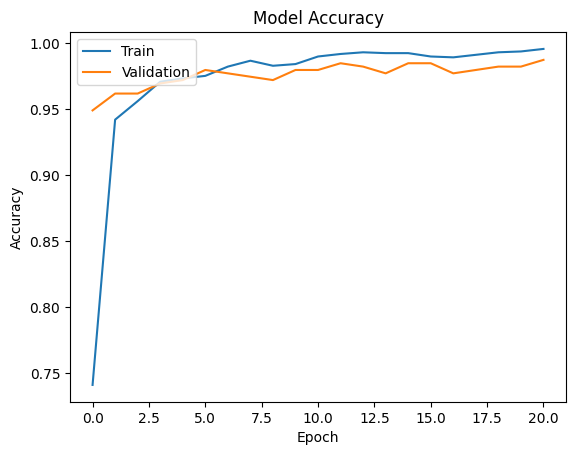

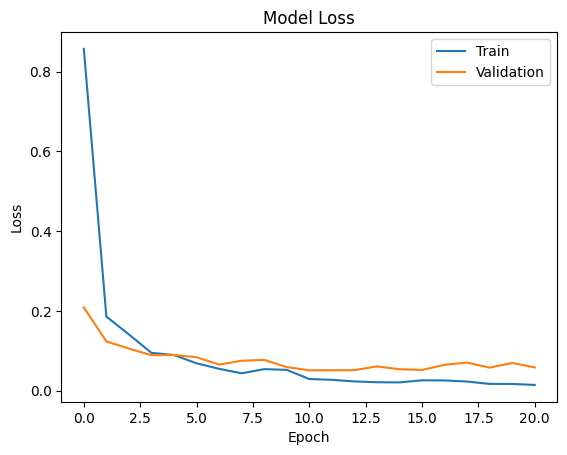

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Training Loss vs Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()